In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import logsumexp
import arviz as az

/Users/cswa648/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


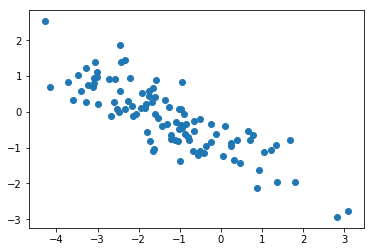

In [2]:
from sklearn.datasets import make_spd_matrix

n = 100
mus = np.random.normal(size=2)
cov = make_spd_matrix(n_dim=2)
X = np.random.multivariate_normal(mean=mus, cov=cov, size=n)
plt.scatter(X[:, 0], X[:, 1])

(array([ 3.,  8., 10., 12., 17., 19., 18.,  7.,  4.,  2.]),
 array([-1.59587042, -0.84166344, -0.08745645,  0.66675053,  1.42095752,
         2.1751645 ,  2.92937149,  3.68357847,  4.43778546,  5.19199244,
         5.94619942]),
 <a list of 10 Patch objects>)

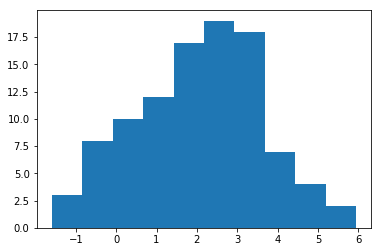

In [3]:
beta = np.random.normal(size=2)
eta = X.dot(beta)
y = np.random.normal(loc=eta)
plt.hist(y)

In [4]:
with pm.Model() as model:
    beta_ = pm.Normal('beta', shape=2)
    eta_ = tt.dot(X, beta_)
    y_ = pm.Normal('y', mu=eta_, observed=y)
    
model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3599.13draws/s]


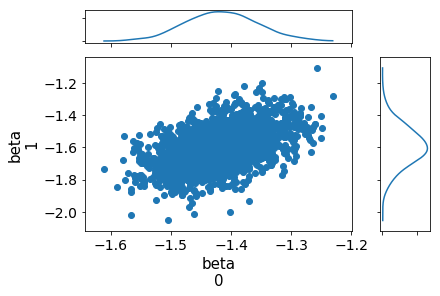

In [5]:
with model:
    trace = pm.sample()
    
inf_data = az.from_pymc3(trace=trace)
az.plot_joint(inf_data, var_names=['beta']);

Average Loss = 141.44:  44%|████▍     | 17759/40000 [00:09<00:11, 1965.56it/s]
Convergence achieved at 17800
Interrupted at 17,799 [44%]: Average Loss = 199.92


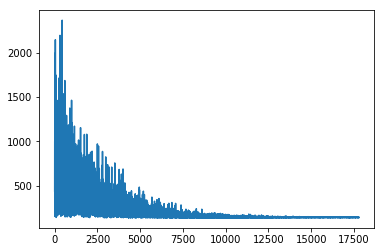

In [6]:
with model:
    advi = pm.ADVI()

tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

fit = advi.fit(n=40000, callbacks=[tracker, pm.callbacks.CheckParametersConvergence(tolerance=0.001)])

plt.plot(fit.hist)

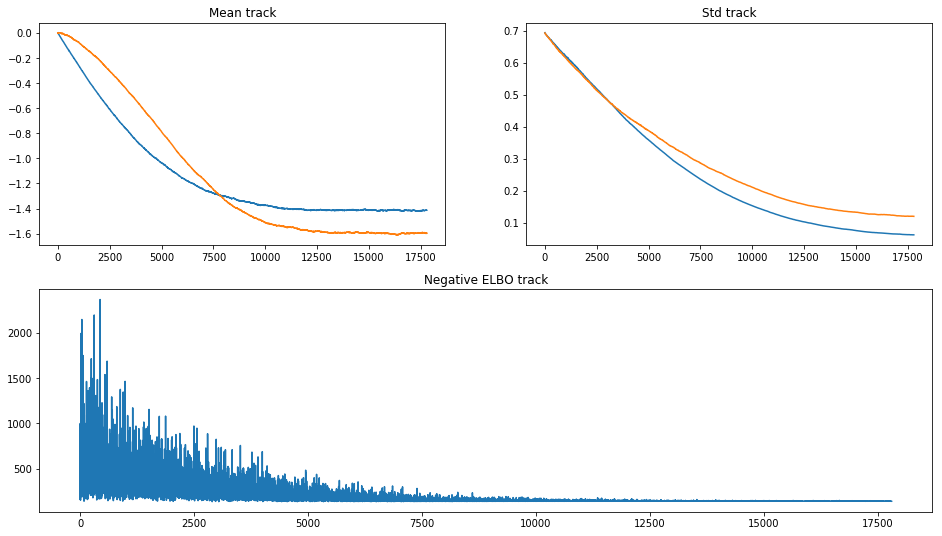

In [7]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

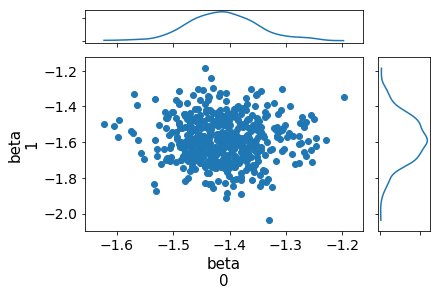

In [8]:
fit_trace = fit.sample()
fit_inf_data = az.from_pymc3(trace=fit_trace)
az.plot_joint(fit_inf_data, var_names=['beta']);

(array([2.000e+00, 6.000e+00, 1.900e+01, 3.700e+01, 1.100e+02, 3.860e+02,
        1.133e+03, 6.958e+03, 1.331e+03, 1.800e+01]),
 array([-17.47322457, -16.39804233, -15.32286008, -14.24767784,
        -13.1724956 , -12.09731335, -11.02213111,  -9.94694887,
         -8.87176662,  -7.79658438,  -6.72140214]),
 <a list of 10 Patch objects>)

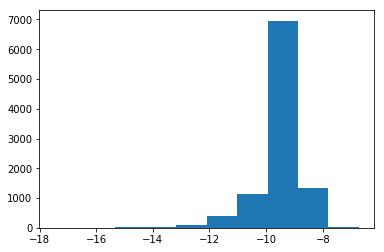

In [9]:
theano.config.compute_test_value = 'off'
log_weight = fit.sized_symbolic_logp - fit.symbolic_logq
n_samples = 10000
log_weights = fit.set_size_and_deterministic(log_weight, n_samples, False).eval()
log_weights_norm = log_weights - logsumexp(log_weights)
plt.hist(log_weights_norm)

In [11]:
def _psislw(lw, reff):
    n = len(lw)
    x = np.copy(lw, order='F')

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(n / 5., 3 * (n / reff) ** 0.5))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    k_min = 1. / 3

    # improve numerical accuracy
    x -= np.max(x)
    # sort the array
    x_sort_ind = np.argsort(x)
    # divide log weights into body and right tail
    xcutoff = max(x[x_sort_ind[cutoff_ind]], cutoffmin)

    expxcutoff = np.exp(xcutoff)
    tailinds, = np.where(x > xcutoff)
    x2 = x[tailinds]
    n2 = len(x2)
    if n2 <= 4:
        # not enough tail samples for gpdfit
        k = np.inf
    else:
        # order of tail samples
        x2si = np.argsort(x2)
        # fit generalized Pareto distribution to the right tail samples
        x2 = np.exp(x2) - expxcutoff
        k, sigma = pm.stats._gpdfit(x2[x2si])

    if k >= k_min and not np.isinf(k):
        # no smoothing if short tail or GPD fit failed
        # compute ordered statistic for the fit
        sti = np.arange(0.5, n2) / n2
        qq = pm.stats._gpinv(sti, k, sigma)
        qq = np.log(qq + expxcutoff)
        # place the smoothed tail into the output array
        x[tailinds[x2si]] = qq
        # truncate smoothed values to the largest raw weight 0
        x[x > 0] = 0
    # renormalize weights
    x -= logsumexp(x)
    # store tail index k

    return x, k

smoothed_log_weights, k = _psislw(log_weights_norm, 1000)
smoothed_log_weights, k 

(array([ -9.69710568,  -9.38392143,  -8.96894421, ..., -10.23540258,
         -9.70086687,  -9.18226363]), 1.035184367789442)

Average Loss = 141.22: 100%|██████████| 40000/40000 [00:37<00:00, 1063.55it/s]
Finished [100%]: Average Loss = 141.22


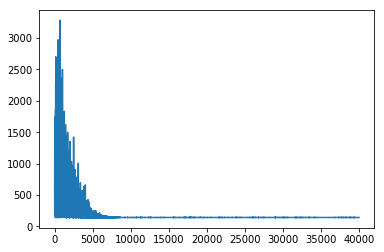

In [19]:
with model:
    fullrank = pm.FullRankADVI()

fr_tracker = pm.callbacks.Tracker(
    mean=fullrank.approx.mean.eval,  # callable that returns mean
    std=fullrank.approx.cov.eval  # callable that returns cov
)

fr_fit = fullrank.fit(n=40000, callbacks=[fr_tracker, pm.callbacks.CheckParametersConvergence(tolerance=0.001)])

plt.plot(fr_fit.hist)

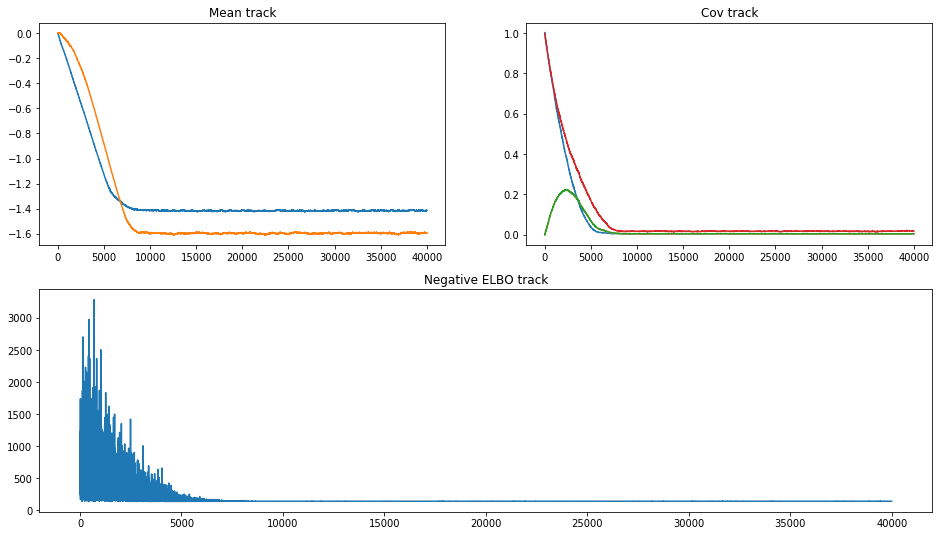

In [30]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(fr_tracker['mean'])
mu_ax.set_title('Mean track')
cov_data = np.stack(fr_tracker['std'])
std_ax.plot(cov_data.reshape((cov_data.shape[0], 4)))
std_ax.set_title('Cov track')
hist_ax.plot(fullrank.hist)
hist_ax.set_title('Negative ELBO track');

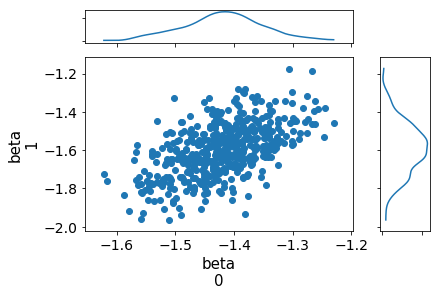

In [34]:
fr_fit_trace = fr_fit.sample()
fr_fit_inf_data = az.from_pymc3(trace=fr_fit_trace)
az.plot_joint(fr_fit_inf_data, var_names=['beta']);

(array([-9.06969247, -9.44158378, -9.17654407, ..., -9.10389706,
        -9.04232856, -9.362019  ]), -0.44864437301250143)

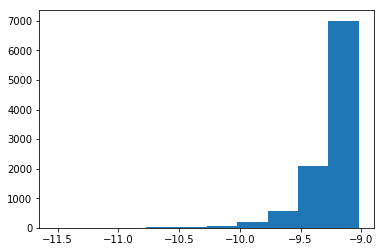

In [35]:
theano.config.compute_test_value = 'off'
fr_log_weight = fr_fit.sized_symbolic_logp - fr_fit.symbolic_logq
n_samples = 10000
fr_log_weights = fr_fit.set_size_and_deterministic(fr_log_weight, n_samples, False).eval()
fr_log_weights_norm = fr_log_weights - logsumexp(fr_log_weights)
plt.hist(fr_log_weights_norm);
_psislw(fr_log_weights_norm, 1000)